# Land Cover Validation with LUCAS dataset

This is an example of the land cover product validation using LUCAS points. The process is using class `Validator` to perform the main validation steps. 

In [1]:
import os
import sys
import yaml 

from osgeo import gdal
from osgeo import gdalconst
import geopandas as gpd
import numpy 

import matplotlib.pyplot as plt 
%matplotlib inline

# Python class with methos to run land cover validation 
from validator import Validator

### 0/ Configure validation 
either by passing `config.yaml` file or as Python dictionary. 

In [3]:
# configuration with sample data 
config_file = './sample_land_cover/config.yaml'

with open(config_file, 'r')as file: 
    file_contents = file.read()
    
print(file_contents)

project:
  name: 'Geoharmonizer Land Cover validation'
  abbrev: 'cz_lc_18'
  run_id: '20210907'

# land cover & reference definitions 
input:
  # raster map 
  path: ./sample_land_cover
  in_ras: cz_land_cover_osm_2018.tif
  ndv: 0
  legend: legend.yaml
  # vector reference 
  in_vec: cz_lucas_points_l1_2018.shp
  ref_att: 'label_l1'

# validation report settings
report:
  path: ./sample_land_cover
  dir_name: 'lc_2018_validation'

# validation points for GIS exporation 
validation_points: 
    file_name: 'validation_points'
    ogr_format: 'ESRI Shapefile'
    epsg: 3035 

    



### 1/ Initialize the validator 

In [3]:
# initilize the validator with passing the config file or Python dictionary with the same structure

In [4]:
validation = Validator(config_file)



Validation project initialized!
Creating report dir at ./sample_land_cover/lc_2018_validation_20210906
Inputs: 
cz_land_cover_osm_2018.tif
cz_lucas_points_l1_2018.shp




### 2/ Check validity of the inputs

In [5]:
# Check you can read the geodata 
inputs_valid = validation.check_inputs()
print('Validation data ready: {}'.format(inputs_valid))

Validation data ready: True


In [6]:
# Check the 'content' of the raster and vector geodata 
with open(config_file) as file:
    cfg = yaml.load(file, Loader=yaml.FullLoader)
    
# Vector data
vector_fn = os.path.join(cfg['input']['path'], cfg['input']['in_vec'])
gdf = gpd.read_file(vector_fn)

gdf.head()

,point_id,survey_dat,gps_altitu,gps_lat,gps_long,nuts0,obs_dist,obs_type,lc1,lc1_perc,label_l1,geometry
0,48262936,2018-05-10,309,49.321800,16.956880,CZ,6.0,1,C33,5,NaN,POINT (4826005.575 2935998.024)
1,47162980,2018-08-02,409,49.799533,15.492019,CZ,22.0,1,B75,4,3.0,POINT (4716021.636 2979995.779)
2,46183058,2018-07-19,242,50.557290,14.193572,CZ,0.0,1,B13,3,2.0,POINT (4617999.865 3057999.905)
3,45262962,2018-07-17,545,49.734924,12.844097,CZ,0.0,1,B35,4,2.0,POINT (4526000.963 2961999.910)
4,47463004,2018-07-24,251,49.993666,15.933803,CZ,0.0,1,B11,4,2.0,POINT (4745999.810 3004000.403)


In [7]:
legend_file = './sample_land_cover/legend.yaml'
with open(legend_file, 'r')as file: 
    legend = file.read()
print(legend)

legend:
    1: Artificial
    2: Cropland
    3: Perenial
    4: Forest
    5: Shrubland
    6: Grassland
    7: Barren
    8: Wetlands
    9: Water
    10: Glaciers



<AxesSubplot:ylabel='label_l1'>

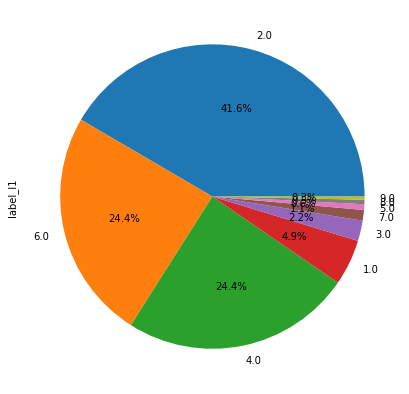

In [8]:
# view distribution of the classes 
attribute = cfg['input']['ref_att']
gdf[attribute].value_counts().plot.pie(figsize=(7, 7), autopct='%1.1f%%')

In [10]:
from ipyleaflet import Map, GeoData, basemaps, LayersControl

m = Map(center=(50,15), zoom = 7, basemap= basemaps.OpenStreetMap.Mapnik)

lucas_gd = GeoData(geo_dataframe = gdf.to_crs("EPSG:4326"),
                   style={'color': 'black', 'fillColor': '#3366cc', 'opacity':0.6, 'weight':1.9, 'dashArray':'2', 'fillOpacity':0.2},
                   name = 'LUCAS points')

m.add_layer(lucas_gd)
m.add_control(LayersControl())

# m

### 3/ Run land cover map and reference overlay

In [11]:
validation.overlay()



Processed: 100% | 4930 reference points.


0

### 4/ Report the validation results 

In [16]:
# short report
# validation.short_report()

In [12]:
# full report
validation.report()



Machine learning validation indicators (per class): 
---
              precision    recall  f1-score   support

           1       0.44      0.84      0.58       185
           2       0.86      0.97      0.91      1801
           3       0.62      0.13      0.22        61
           4       0.93      0.90      0.92       989
           5       0.15      0.18      0.16        17
           6       0.91      0.63      0.75       952
           7       0.62      0.11      0.19        46
           8       0.25      0.27      0.26        11
           9       0.30      0.33      0.32         9

    accuracy                           0.84      4071
   macro avg       0.56      0.49      0.48      4071
weighted avg       0.86      0.84      0.84      4071

Classical LC validation indicators: 
---
overall_accuracy :  0.8416
producers_accuracy :  0.8583
users_accuracy :  0.8416
kappa :  0.7670




0

In [13]:
# Save the validation report to text file for future use
validation.save_report()

Saving validation report:
---
cz_lc_18_validation_report.txt




0

### 5/ Plot confusion matrix

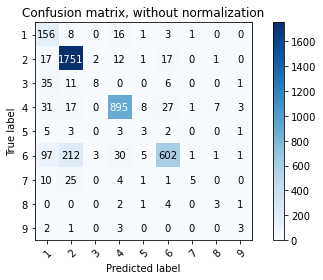

0

In [14]:
validation.show_confusion_matrix()

In [16]:
print(legend)

legend:
    1: Artificial
    2: Cropland
    3: Perenial
    4: Forest
    5: Shrubland
    6: Grassland
    7: Barren
    8: Wetlands
    9: Water
    10: Glaciers



0

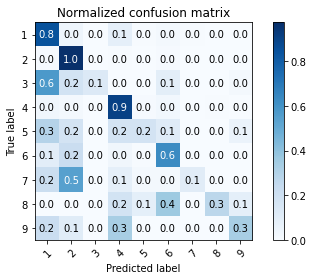

In [17]:
validation.save_normalized_confusion_matrix()

In [ ]:
# You can also save the plots into the validation directory for later use 
# validation.save_confusion_matrix()
# validation.save_normalized_confusion_matrix()

### 6/ Save the validation overlay geodata to vector for exploration in GIS

In [18]:
validation.save_vec()

Saving validation data:
---
Vector data: validation_points.shp created from overlay data


0

### Classes aggregation 

In [19]:
config_aggregation = {
    'project':
      {'name': 'Geoharmonizer Land Cover validation', 
      'abbrev': 'cz_lc_18', 
      'run_id': '20210907'
      }, 
    'input':
      {'path': './sample_land_cover', 
      'in_ras': 'cz_land_cover_osm_2018.tif', 
      'ndv': 0, 
      'legend': 'legend.yaml', 
      'in_vec': 'cz_lucas_points_l1_2018.shp', 
      'ref_att': 'label_l1'
      }, 
    'report':
      {'path': './sample_land_cover', 
      'dir_name': 'lc_2018_validation_aggregation'
      }, 
    'validation_points': 
      {'file_name': 'validation_points', 
       'ogr_format': 'ESRI Shapefile',
       'epsg': 3035 
      }
}

In [20]:
validation_lc_aggregated = Validator(config_aggregation)



Validation project initialized!
Creating report dir at ./sample_land_cover/lc_2018_validation_aggregation_20210906
Inputs: 
cz_land_cover_osm_2018.tif
cz_lucas_points_l1_2018.shp




In [21]:
# 2: agriculture (arable land & grassland)
aggregartion = {
    2: [2, 6]
}

In [22]:
validation_lc_aggregated.overlay(aggregartion)



Processed: 100% | 4930 reference points.


0

In [23]:
validation_lc_aggregated.report()



Machine learning validation indicators (per class): 
---
              precision    recall  f1-score   support

           1       0.65      0.90      0.76       174
           2       1.00      1.00      1.00      3113
           3       1.00      0.18      0.31        44
           4       0.97      0.95      0.96       945
           5       0.21      0.25      0.23        12
           7       0.71      0.25      0.37        20
           8       0.30      0.43      0.35         7
           9       0.33      0.38      0.35         8

    accuracy                           0.97      4323
   macro avg       0.65      0.54      0.54      4323
weighted avg       0.97      0.97      0.97      4323

Classical LC validation indicators: 
---
overall_accuracy :  0.9683
producers_accuracy :  0.9735
users_accuracy :  0.9683
kappa :  0.9267




0

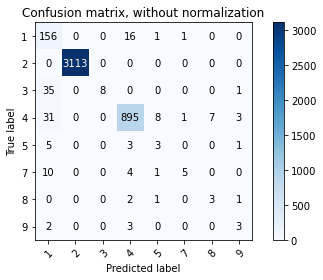

0

In [24]:
validation_lc_aggregated.show_confusion_matrix()